In [51]:
import scanpy.api as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from nero import Harmonia
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl

In [52]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False
sc.settings.verbosity = 5
sc.settings.set_figure_params(dpi=80)

In [53]:
exps = dict()
for exp in range(5):
    exps[exp] = dict()

In [54]:
exps[0]['path'] = '/myvol/data2/data/20190831/20180831_L10C.h5ad'
exps[1]['path'] = '/myvol/data2/data/20190831/20180831_L20C1.h5ad'
exps[2]['path'] = '/myvol/data2/data/20190831/20180831_L20T.h5ad'
exps[3]['path'] = '/myvol/data2/data/20190831/20180831_L30C.h5ad'
exps[4]['path'] = '/myvol/data2/data/20190831/20180831_L30C8.h5ad'

In [55]:
for exp in exps:
    exps[exp]['adata'] = sc.read_h5ad(exps[exp]['path'])

In [56]:
for exp in exps:
    exps[exp]['label'] = exps[exp]['path'].split('/')[-1]

In [57]:
adata = exps[0]['adata'].concatenate([exps[exp]['adata'] for exp in range(1,5)],
                                           batch_categories=
                                           [exps[exp]['label'] for exp in range(5)]).copy()

In [58]:
human_genes = [i for i in exps[0]['adata'].var_names if i.startswith('hg19_')]
mouse_genes = [i for i in exps[0]['adata'].var_names if i.startswith('mm10_')]

Extract out separate adatas for each genome, and extract out UMIs as "n_counts" in obs (per cell) and in the vars (per gene).

In [59]:
adata_human = adata[:,human_genes].copy()
adata_human.var_names = [i[5:] for i in adata_human.var_names] # no need for the genome tag at the beginning anymore
adata_mouse = adata[:,mouse_genes].copy()
adata_mouse.var_names = [i[5:] for i in adata_mouse.var_names]

In [60]:
human_min_counts = 1e3
human_min_genes = 5e2

mouse_min_counts = 30
mouse_min_genes = 15

In [61]:
adata.obs['human_cells_counts_bool'] = sc.pp.filter_cells(adata_human,min_counts=human_min_counts,inplace=False)[0]
adata.obs['human_cells_counts_vals'] = sc.pp.filter_cells(adata_human,min_counts=human_min_counts,inplace=False)[1]

adata.obs['human_cells_genes_bool'] = sc.pp.filter_cells(adata_human,min_counts=human_min_genes,inplace=False)[0]
adata.obs['human_cells_genes_vals'] = sc.pp.filter_cells(adata_human,min_counts=human_min_genes,inplace=False)[1]

adata.obs['mouse_cells_counts_bool'] = sc.pp.filter_cells(adata_mouse,min_counts=mouse_min_counts,inplace=False)[0]
adata.obs['mouse_cells_counts_vals'] = sc.pp.filter_cells(adata_mouse,min_counts=mouse_min_counts,inplace=False)[1]

adata.obs['mouse_cells_genes_bool'] = sc.pp.filter_cells(adata_mouse,min_counts=mouse_min_genes,inplace=False)[0]
adata.obs['mouse_cells_genes_vals'] = sc.pp.filter_cells(adata_mouse,min_counts=mouse_min_genes,inplace=False)[1]

filtered out 43869 cells that have less than 1000.0 counts
filtered out 43869 cells that have less than 1000.0 counts
filtered out 43127 cells that have less than 500.0 counts
filtered out 43127 cells that have less than 500.0 counts
filtered out 3233 cells that have less than 30 counts
filtered out 3233 cells that have less than 30 counts
filtered out 2236 cells that have less than 15 counts
filtered out 2236 cells that have less than 15 counts


In [62]:
human = (adata.obs['human_cells_counts_bool'] == True) & (adata.obs['human_cells_genes_bool'] == True) & \
(adata.obs['mouse_cells_counts_bool'] == False) & (adata.obs['mouse_cells_genes_bool'] == False)

mouse = (adata.obs['mouse_cells_counts_bool'] == True) & (adata.obs['mouse_cells_genes_bool'] == True) & \
(adata.obs['human_cells_counts_bool'] == False) & (adata.obs['human_cells_genes_bool'] == False)

In [63]:
columns = adata.obs.columns.tolist()
adata_human = adata_human[human].copy()
adata_human.obs[columns] = adata.obs.loc[human,columns]
adata_mouse = adata_mouse[mouse].copy()
adata_mouse.obs[columns] = adata.obs.loc[mouse,columns]

In [64]:
with open('/myvol/data2/data/concat2.keepcells.txt','r') as file:
    keepcells = [i.strip() for i in file.readlines()]

In [65]:
adata_mouse = adata_mouse[keepcells].copy()

In [66]:
sc.pp.filter_genes(adata_mouse,min_counts=60)
sc.pp.filter_genes(adata_mouse,min_cells=60)

filtered out 42726 genes that are detected in less than 60 counts
filtered out 1504 genes that are detected in less than 60 cells


In [67]:
genelist = adata_mouse.var_names.tolist()
mito_genes_names_mouse = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes_mouse = [genelist.index(gn) for gn in mito_genes_names_mouse]

In [68]:
adata_mouse.obs['percent_mito_mouse'] = np.ravel(np.sum(adata_mouse[:, mito_genes_mouse].X, axis=1)) / np.ravel(np.sum(adata_mouse.X, axis=1))

In [69]:
def process1(adata):
    sc.pp.log1p(adata)
    sc.pp.normalize_per_cell(adata)
    return adata

In [70]:
adata_mouse = process1(adata_mouse)

    normalizing by total count per cell
        finished (0:00:00.07): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


In [71]:
def process2_check(adata,min_mean=0.0125, min_disp=0.5):    # Extract out highly variable genes, but don't subset just yet.
    hv_adata = adata.copy()
    sc.pp.highly_variable_genes(hv_adata, flavor='cell_ranger',inplace=True, min_mean=min_mean, min_disp=min_disp, n_bins=100)
    print(sum(hv_adata.var['highly_variable'].values))
    sc.pl.highly_variable_genes(hv_adata,log=True)

    extracting highly variable genes
        finished (0:00:00.59)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
1087


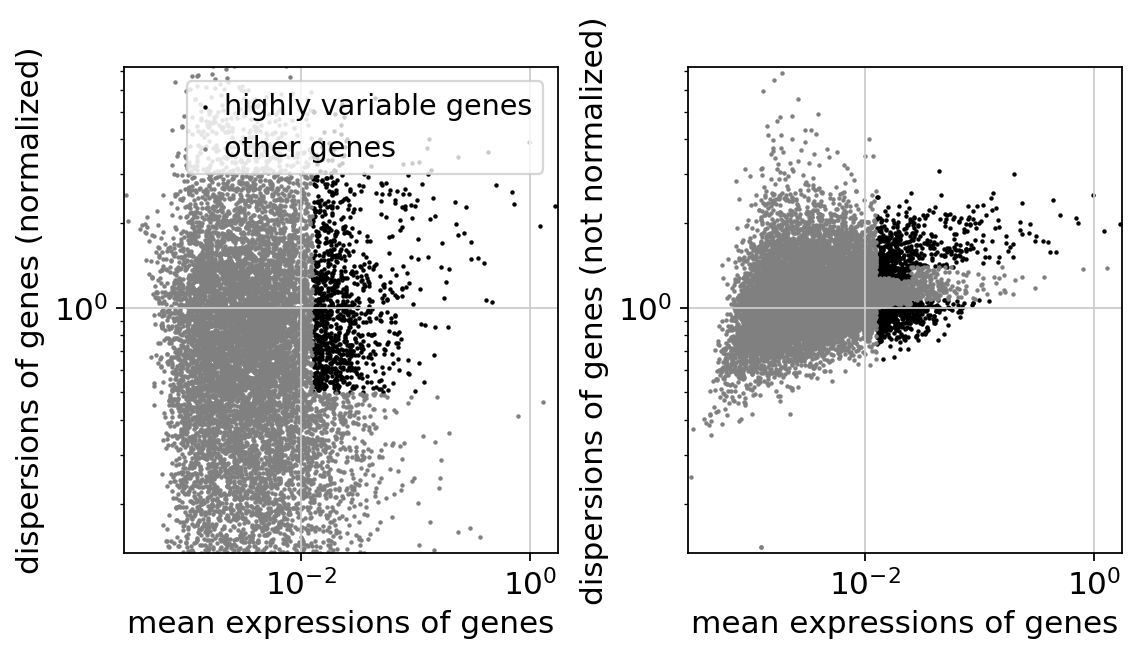

In [72]:
process2_check(adata_mouse)

In [73]:
my_min_mean = 0.001
my_min_disp = 0.7

    extracting highly variable genes
        finished (0:00:00.51)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
5329


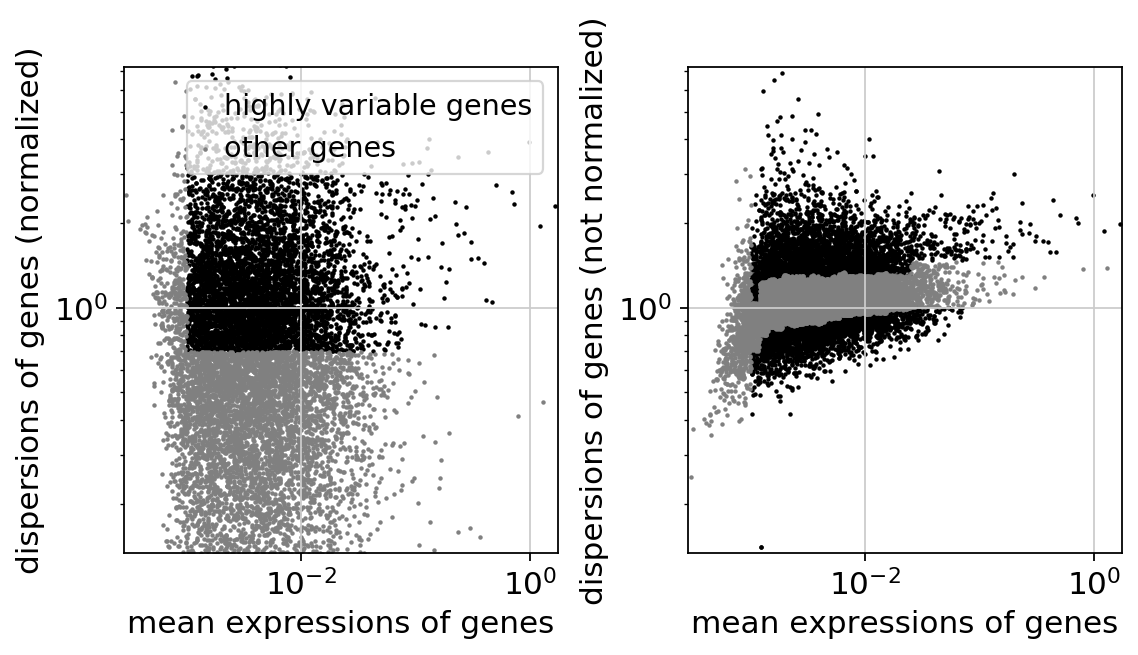

In [74]:
process2_check(adata_mouse, min_mean=my_min_mean, min_disp=my_min_disp)

In [75]:
def process2(adata, min_mean, min_disp):    # Extract out highly variable genes, but don't subset just yet.
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger',inplace=True, subset=True, min_mean=min_mean, min_disp=min_disp, n_bins=100)

In [76]:
process2(adata_mouse,min_mean=my_min_mean, min_disp=my_min_disp)

    extracting highly variable genes
        finished (0:00:00.51)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [77]:
warnings.filterwarnings('ignore')
sc.pp.combat(adata_mouse,covariates=['percent_mito_mouse','n_counts','human_cells_counts_vals'])
warnings.filterwarnings('default')

Standardizing Data across genes.

Found 5 batches

Found 3 numerical variables:
	percent_mito_mouse, n_counts, human_cells_counts_vals

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [78]:
sc.pp.scale(adata_mouse, max_value=10)

    ... clipping at max_value 10


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:06.34)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


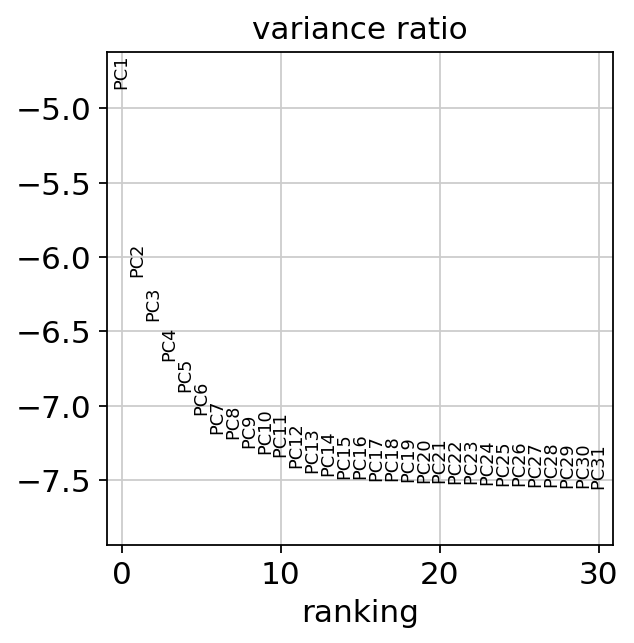

In [79]:
sc.pp.pca(adata_mouse)
sc.pl.pca_variance_ratio(adata_mouse,log=True)

In [80]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(adata_mouse,n_neighbors=15,n_pcs=14) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 14
    computed neighbors (0:00:06.88)
    computed connectivities (0:00:01.09)
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [81]:
sc.tl.leiden(adata_mouse,resolution=0.7)

running Leiden clustering
    finished (0:00:15.93) --> found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


In [82]:
sc.tl.umap(adata_mouse)

computing UMAP
    using 'X_pca' with n_pcs = 14
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished (0:00:38.19) --> added
    'X_umap', UMAP coordinates (adata.obsm)


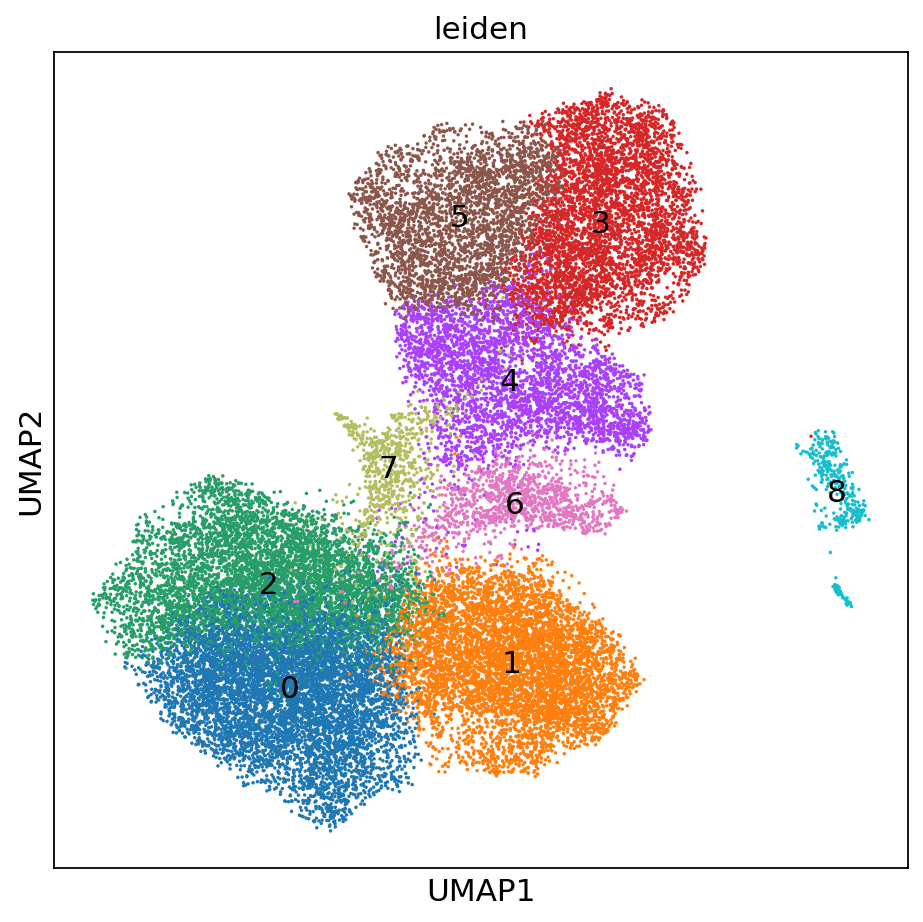

In [83]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.umap(adata_mouse,color='leiden',ax=ax, legend_loc='on data', return_fig=False, show=False, size=10, legend_fontweight='normal')
plt.tight_layout()

In [84]:
sc.settings.verbosity = 0

In [85]:
sc.tl.rank_genes_groups(adata_mouse,groupby='leiden')

/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:222: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


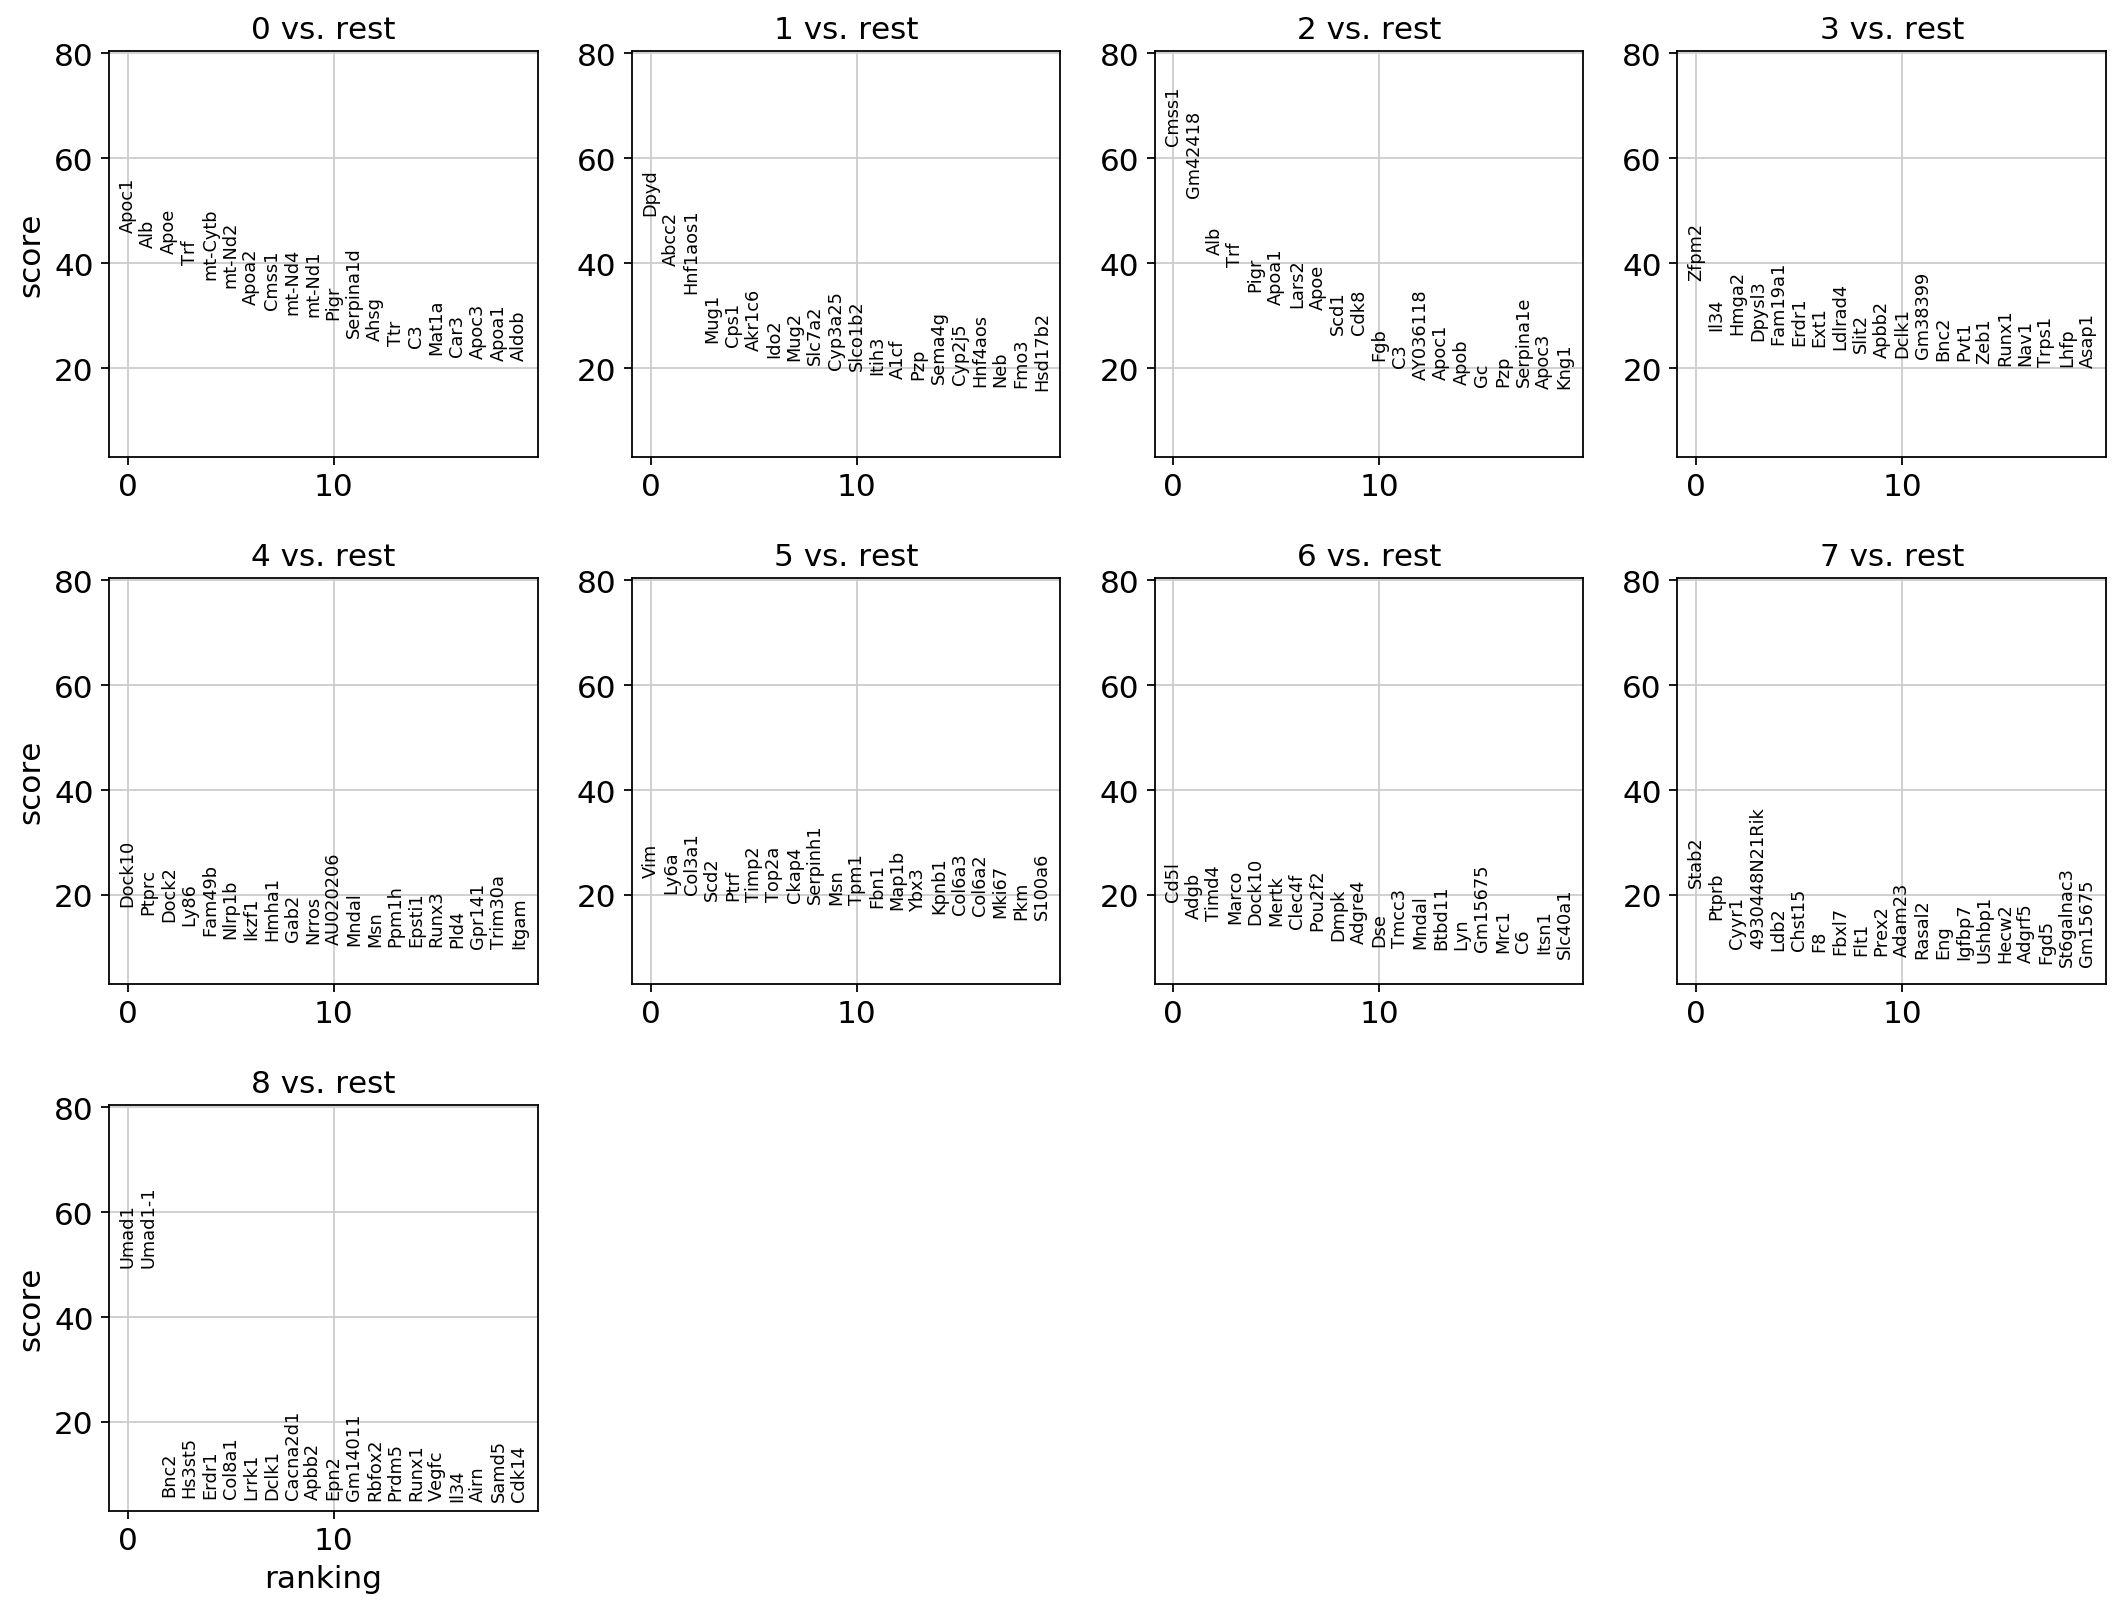

In [86]:
sc.pl.rank_genes_groups(adata_mouse,n_genes=20)

Yah gotta be kidding, Umad1 again? I confirmed, I removed the cells that I thought were expressing it. How is that possible?

/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


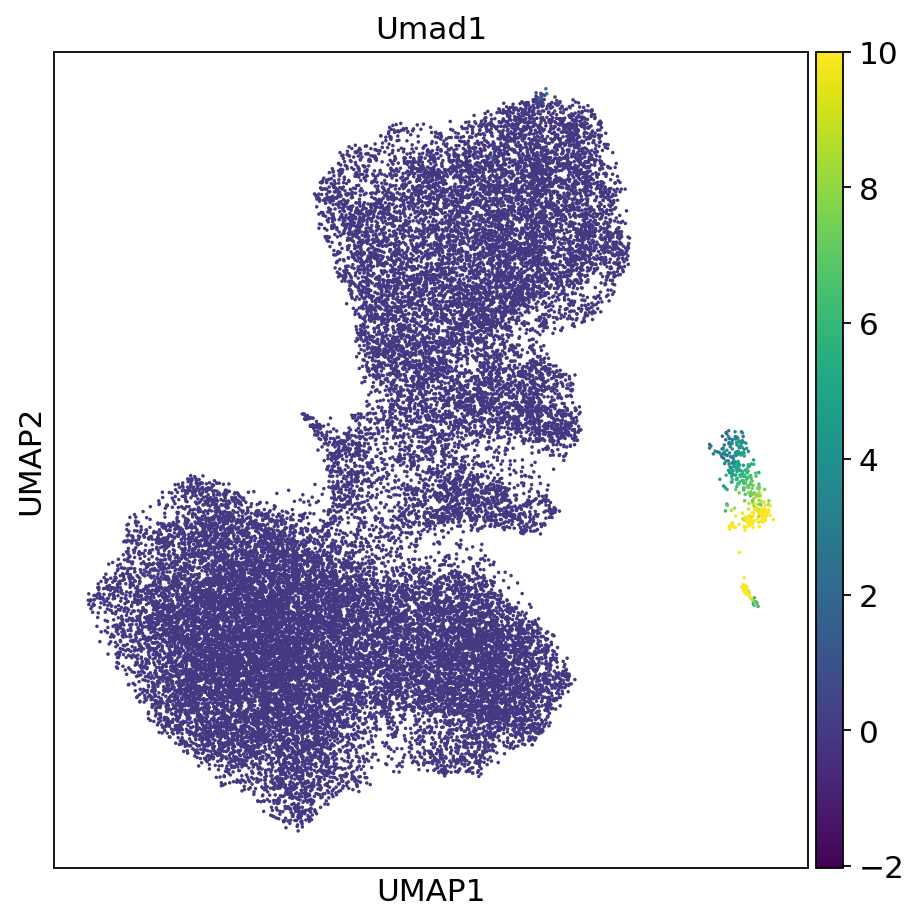

In [87]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.umap(adata_mouse,color='Umad1',ax=ax, legend_loc='on data', return_fig=False, show=False, size=10, legend_fontweight='normal')
plt.tight_layout()

In [88]:
keepcells = adata_mouse.obs_names[[i != '8' for i in adata_mouse.obs['leiden'].values]].tolist()

In [89]:
len(keepcells)

31362

In [90]:
len(adata_mouse)

31716

In [91]:
with open('/myvol/data2/data/concat3.keepcells.txt','w') as file:
    for i in keepcells:
        file.write(i + '\n')